In [96]:
import tensorflow as tf
import os
import random
import numpy as np
import helpers
import cv2 as cv
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [97]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 80
IMG_HEIGHT = 80
IMG_CHANNELS = 3

TRAIN_PATH_IMAGES = 'training/images/'
TRAIN_PATH_GROUNDTRUTH = 'training/groundtruth/'
TEST_PATH = 'test_set_images/'

train_ids = os.listdir(TRAIN_PATH_IMAGES)
test_ids = os.listdir(TEST_PATH)

train_len = len(train_ids)*25
test_len = len(test_ids)*64

X_train = np.zeros((train_len, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((train_len, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

In [98]:
def split_into_patches(img, patchsize):
    assert patchsize % 16 == 0 and 400 % patchsize == 0, "Invalid patchsize. Must be in {16, 80, 400}."
    sub_images = []
    width = img.shape[0]
    height = img.shape[1]
    
    if ((not width % patchsize == 0) or (not width % patchsize == 0)):
        img = cv.copyMakeBorder(img, 0, patchsize - (height % patchsize), 0, patchsize - (width % patchsize), cv.BORDER_CONSTANT,value=(0, 0, 0))
        width = img.shape[0]
        height = img.shape[1]
    
    for x in range(width // patchsize):
        for y in range(height // patchsize):
            tlc = (x*patchsize, y*patchsize) # Top left corner
            sub_images.append(img[tlc[0]:tlc[0]+patchsize,tlc[1]:tlc[1]+patchsize])
    return np.array(sub_images)



In [99]:
print('Resizing training images and masks')
position1 = 0
position2 = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    imgs = imread(TRAIN_PATH_IMAGES + id_)[:,:,:IMG_CHANNELS]  
    imgs = split_into_patches(imgs,80)
    for img in imgs:
        X_train[position1] = img
        position1 += 1
    masks = imread(TRAIN_PATH_GROUNDTRUTH + id_)
    masks = split_into_patches(masks,80)
    masks = np.expand_dims(masks, axis=3)
    for mask in masks:
        Y_train[position2] = mask
        position2 += 1

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.50it/s]


Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.84it/s]


Done!
We pad the test images to be able to make patches of 80 :


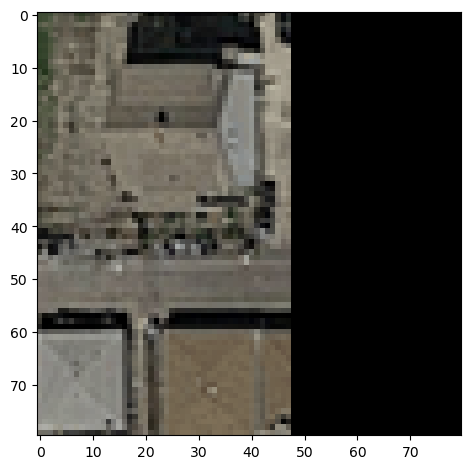

In [100]:
  

# test images
X_test = np.zeros((test_len, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
PATCHES = 64
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    imgs = imread(path + '/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    imgs = split_into_patches(imgs,80)
    for i, img in enumerate(imgs):
        X_test[n*PATCHES + i] = img

print('Done!')
print('We pad the test images to be able to make patches of 80 :')
imshow(imgs[7])
plt.show()

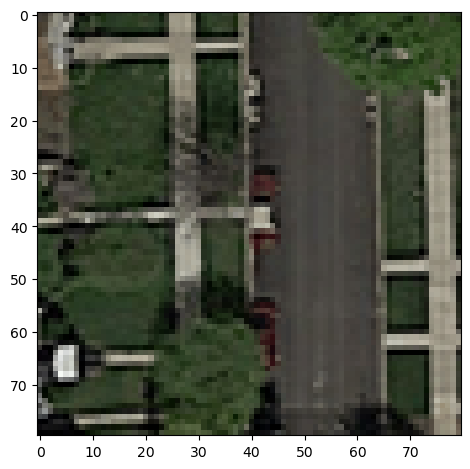

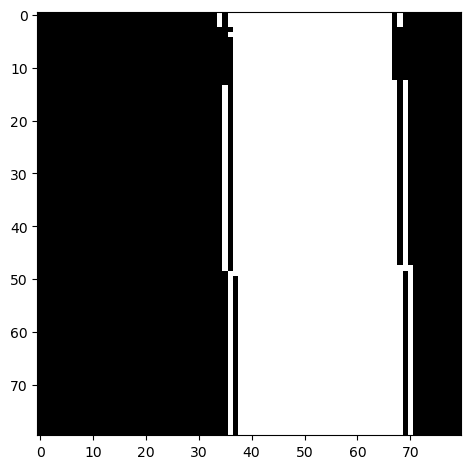

In [101]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [102]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 80, 80, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 80, 80, 16)   448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 80, 80, 16)   0           conv2d_38[0][0]                  
____________________________________________________________________________________________

In [103]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

####################################

Epoch 1/25
141/141 [==============================] - 54s 368ms/step - loss: 0.5160 - accuracy: 0.7746 - val_loss: 0.5293 - val_accuracy: 0.7488
Epoch 2/25
141/141 [==============================] - 50s 354ms/step - loss: 0.4703 - accuracy: 0.7776 - val_loss: 0.4752 - val_accuracy: 0.7488
Epoch 3/25
141/141 [==============================] - 50s 352ms/step - loss: 0.4511 - accuracy: 0.7788 - val_loss: 0.4801 - val_accuracy: 0.7702
Epoch 4/25
141/141 [==============================] - 50s 357ms/step - loss: 0.4213 - accuracy: 0.7971 - val_loss: 0.4707 - val_accuracy: 0.7550
Epoch 5/25
141/141 [==============================] - 50s 352ms/step - loss: 0.3824 - accuracy: 0.8205 - val_loss: 0.4604 - val_accuracy: 0.7765
Epoch 6/25
141/141 [==============================] - 50s 351ms/step - loss: 0.3461 - accuracy: 0.8475 - val_loss: 0.3803 - val_accuracy: 0.8239
Epoch 7/25
141/141 [==============================] - 50s 354ms/step - loss: 0.3070 - accuracy: 0.8672 - val_loss: 0.4076 - val_ac

In [104]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

100/100 [==============================] - 13s 128ms/step


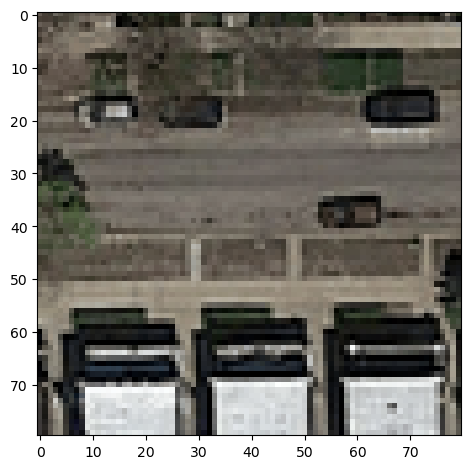

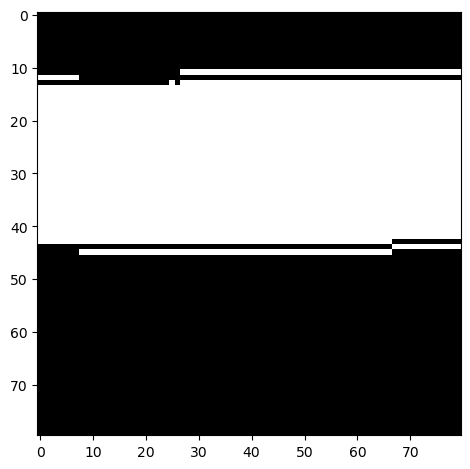

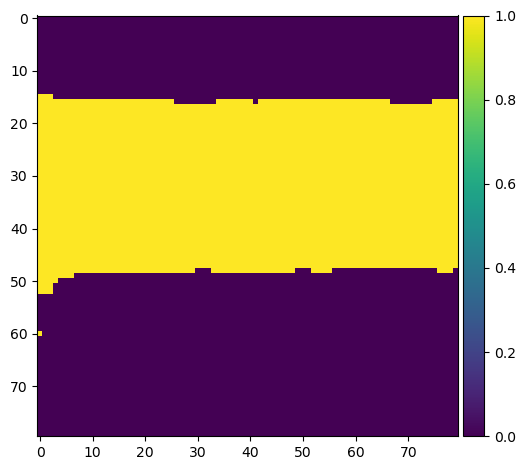

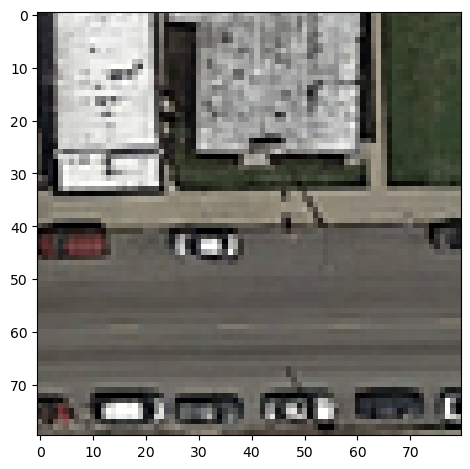

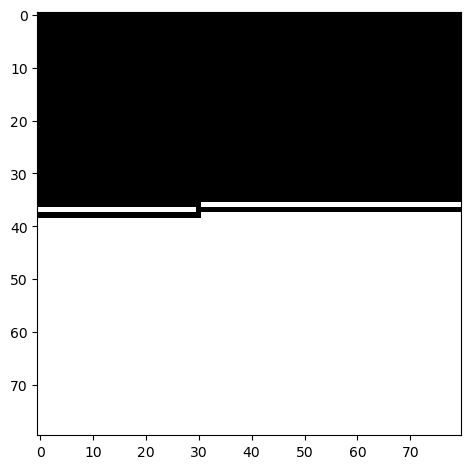

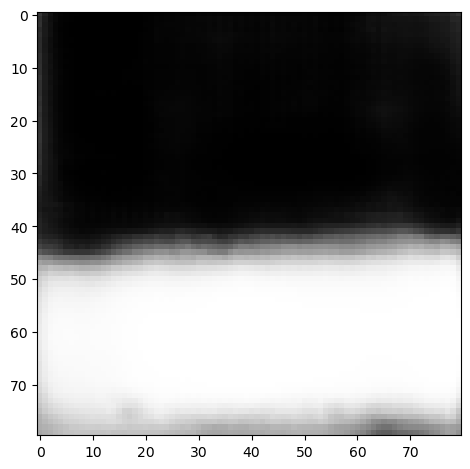

In [154]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val[ix]))
plt.show()

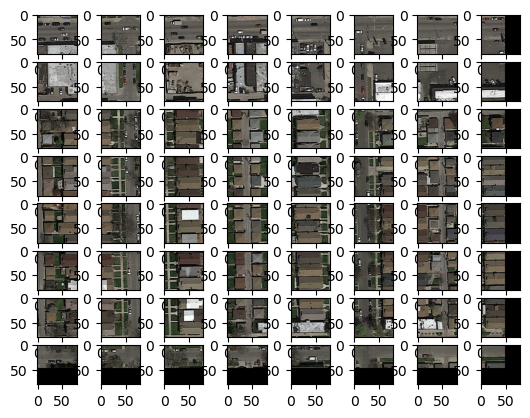

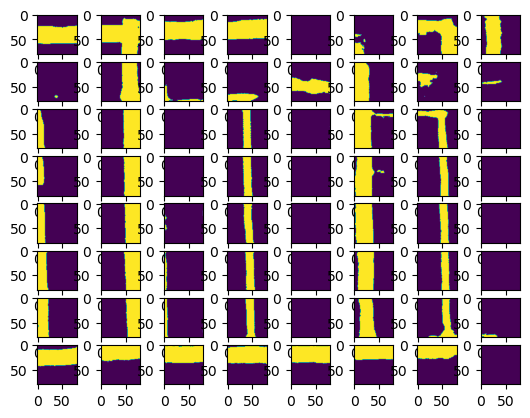

In [74]:
# Look at the prediction for the first image
fig, ax = plt.subplots(8,8) # Works for patchsize = 80
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(X_test[8*i + j])
fig1, ax1 = plt.subplots(8,8) # Works for patchsize = 80
for i in range(8):
    for j in range(8):
        ax1[i,j].imshow(np.squeeze(preds_test_t[8*i + j]))

In [152]:
submission = []
for i, pred in enumerate(preds_test):
    img_id = test_ids[i//64]
    # Format the image id
    id = img_id.split('_')[1].zfill(3)
    preds = split_into_patches(pred, 16)
    for j, img in enumerate(preds):
        # Calculate the index of each subimage (in terms of pixels)
        x = 16*(5*((i % 64) % 8 ) + j % 5)
        y = 16*(5*((i % 64) // 8) + j // 5)
        # Don't add the padding predictions
        if x < 608 and y < 608:
            # For now we calculate the average over all the pixels and check if it's above 0.5
            submission.append((f"{id}_{x}_{y}", 1 if img.mean() > 0.5 else 0))
np.savetxt("predictions.csv", np.asarray(submission), fmt="%s", delimiter=",", newline="\n", header="id,prediction", comments="")